<a href="https://colab.research.google.com/github/leinaxd/NOTES/blob/main/digital_image_processing/notebooks/13_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMAGE SEGMENTATION
```
Author: Eichenbaum Daniel
Email: eichenbaum.daniel@gmail.com
```

This is a practical demo to understand the theory behind:
  ```
DIP Lecture 12a: Image Segmentation ¬Rich Radke
    https://www.youtube.com/watch?v=ZF-3aORwEc0&list=PLuh62Q4Sv7BUf60vkjePfcOQc8sHxmnDX&index=14

Textbook: 10.4-10.6 Digital Image Processing
  Gonzalez and Woods, 4th ed.  
  https://www.amazon.com/-/es/Rafael-Gonzalez/dp/0133356728  
  ```

In this exercize we analyze an X-Ray image of a weld containing several cracks and porosities, we ilustrate the use of region growing by segmenting the defective weld regions. These regions could be used in applications such as weld inspection, historical studies or for controlling an automated welding system.

(111, 453, 3)


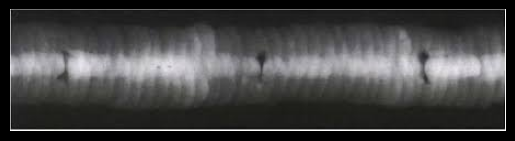

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import cv2

plt.style.use('dark_background')

url = "https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/Lecture%2013/weld_defect.jpg" #@param {'type':'string'}
with urllib.request.urlopen(url) as url:
    img = plt.imread(url, format='jpg')
plt.imshow(img)
plt.axis('off')

print(img.shape)

r_mask = img[:, :, 0]
g_mask = img[:, :, 1]
b_mask = img[:, :, 2]

#turn image to gray
g_img = r_mask*0.2989 + g_mask*0.5870 + b_mask*0.1140
u_img = np.uint8(g_img)

Let
- I(x,y) denote an input image
- S(x,y) denote a  seed array containing 1s at the locations of seeds points 0s otherwise.
- Q denote a predicate to be applied at each location (x,y).

Then a basic **Region Growingn algorithm** based on 8-conectivity may be stated as follows.

1. Find all connected components in S(x,y) and reduce each connected component to one pixel; Label all such pixels found as 1. All other pixels are labeled 0.

2. Form an image $f_Q$ such that, at each point $(x,y)$, $f_Q(x,y)=1$ if the input image satisfies a given predicate $Q$, at those coordinates, and $f_Q(x,y)=0$ otherwise.

3. Let $g$ be an image formed by appending to each seed point in $S$ all the 1-valued points in $f_Q$ that are 8-connected to that seed point.

4. Label each connected component in $g$ with a different region label (e.g. integers or letters). This is the segmented image obtained by region growing.

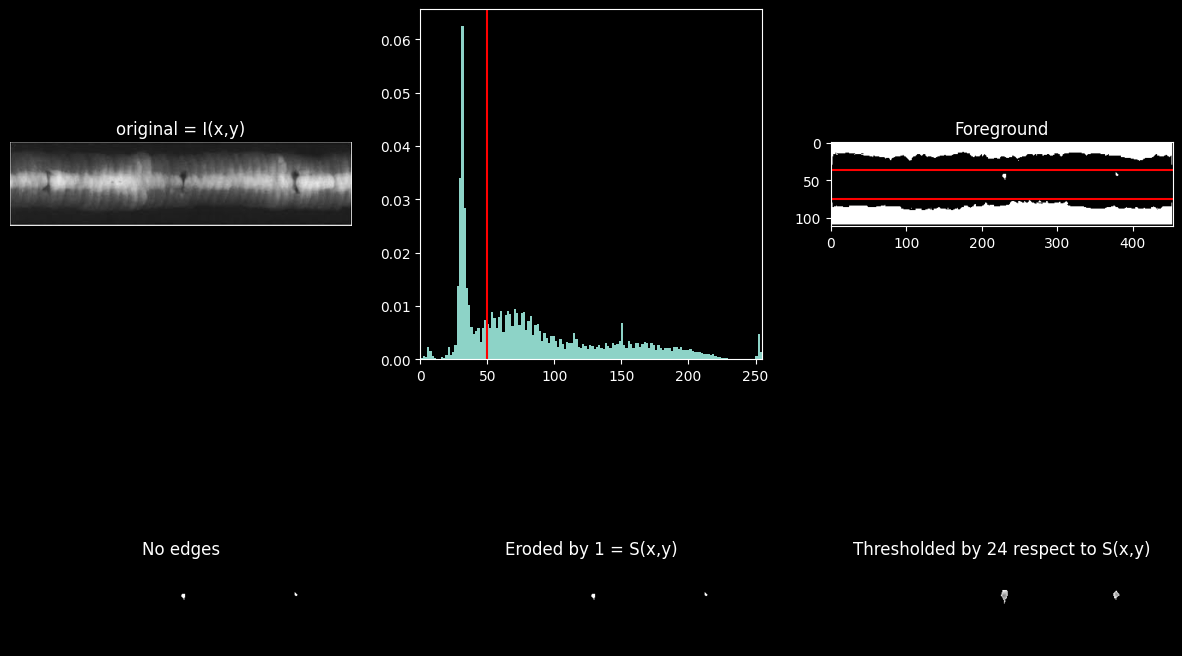

In [178]:
from operator import rshift
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0][0].imshow(g_img, cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title('original = I(x,y)');

#@markdown 1. Determine the seed points by thresholding the image
nbins=150 #@param {'type':'integer'}
th = 50 #@param {'type':'integer'}
ax[0][1].hist(g_img.flatten(), bins=nbins, density=True);
ax[0][1].axvline(th, color='r')
ax[0][1].set_xlim([0, 255]);
im_1 = (g_img <= th)
im_1 = np.uint8(im_1)
f_im_1 = im_1.flatten()
ax[0][2].imshow(im_1, cmap='gray')
ax[0][2].set_title(f'Foreground');

#@markdown 2. Preprocessing
cut_edge_at = 36 #@param {'type':'integer'}
ax[0][2].axhline(cut_edge_at, color='r')
ax[0][2].axhline(im_1.shape[0]-cut_edge_at, color='r')

im_2 = im_1.copy()
im_2[:cut_edge_at, :] = 0
im_2[-cut_edge_at:, :] = 0
ax[1][0].imshow(im_2, cmap='gray')
ax[1][0].set_title(f'No edges');
ax[1][0].axis('off');

eroded_size = 1 #@param {'type':'integer'}
kernel = np.ones((eroded_size,eroded_size), np.uint8)
im_3 = cv2.erode(im_2, kernel)
ax[1][1].imshow(im_3, cmap='gray')
ax[1][1].set_title(f'Eroded by {eroded_size} = S(x,y)');
ax[1][1].axis('off');

#@markdown 3. Define the predicate $Q=\{True\ if\ |S_8(x,y) - I(x,y)|\le T$
T = 24 #@param {'type':'integer'}
nIter = 20 #@param {'type':'integer'}

R,C = g_img.shape
im_4 = np.zeros_like(g_img)
kernel = np.ones((3,3),np.uint8)

for r in range(R):
    for c in range(C):
        if im_3[r,c] == 0: continue
        #Grow the seed
        similar_img = np.uint8(np.abs(g_img - g_img[r,c]) <= T) #all points similar in intensity

        S_8 = im_3.copy()
        for i in range(nIter):
            S_8 = cv2.dilate(S_8, kernel,iterations=1) #Is it connected?
            S_8 = S_8 * similar_img

        im_4 += S_8 #apply mask for similarity and connectivity

im_4 = (im_4>0)*g_img
ax[1][2].imshow(im_4, cmap='gray')
ax[1][2].set_title(f'Thresholded by {T} respect to S(x,y)');
ax[1][2].axis('off');